In [1]:
#Reference Code:https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb?fbclid=IwAR3LwHhYzMV6lym8ABf0aEkx1BKibHeKN-rV8JAzAQV9OziOr4fpefkF5qk

I am running the code using Google Colab so there are some "special" commands i need to run everytime when I start the kernel on Google Collab. 

In [0]:
#install torch everytime
!pip install -q torch

tcmalloc: large alloc 1073750016 bytes == 0x60eb0000 @  0x7f181e2f22a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [2]:
import numpy as np
from collections import Counter
import pickle as pkl
import random
import pdb
import pandas as pd
import string
import re
import unicodedata
import os
import time
import math

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.nn import functional

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline

import logging

#specify SOS(start of sentence) and EOS(end of sentence)
#specify <pad> and <unk> tokens
#specify maximum vocabulary size
#specify MAX_LENGTH of sentences to 30
PAD_IDX = 2
UNK_IDX = 3
SOS_token = 0
EOS_token = 1
MAX_VOCAB_SIZE = 70000
MAX_LENGTH = 30
BATCH_SIZE = 32

train_en = 'data/train.tok.en'
train_zh = 'data/train.tok.zh'
val_en = 'data/dev.tok.en'
val_zh = 'data/dev.tok.zh'



In [0]:
#user GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print("Currently using GPU")

Currently using GPU


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
folder_path = os.getcwd() + '/gdrive/My Drive/NLP/Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Load Pre-Trained Embedding Matrix
I used both Chinese and English embedding matrix from FastText(https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)

In [0]:
def load_emb_matrix(language):
    #load fasttext word vectors
    words_to_load = MAX_VOCAB_SIZE
    if language == 'english':
        file = 'wiki-news-300d-1M-subword.vec'
    if language == 'chinese':
        file = 'cc.zh.300.vec'
    

    with open(folder_path + 'data/' + file) as f:
        #remove the first line
        firstLine = f.readline()
        loaded_embeddings = np.zeros((words_to_load + 4, 300))
        words2id = {}
        idx2words = {}
        #ordered_words = []
        for i, line in enumerate(f):
            if i >= words_to_load: 
                break
            s = line.split()
            loaded_embeddings[i + 4 , :] = np.asarray(s[1:])
            words2id['<SOS>'] = SOS_token
            words2id['<EOS>'] = EOS_token
            words2id['<pad>'] = PAD_IDX
            words2id['<unk>'] = UNK_IDX
            words2id[s[0]] = i + 4
            
            idx2words[0] = '<SOS>'
            idx2words[1] = '<EOS>'
            idx2words[2] = '<pad>'
            idx2words[3] = '<unk>'
            
            idx2words[i + 4] = s[0]
   

    return words2id,idx2words,loaded_embeddings

In [0]:
def generate_weights_matrix(idx2words,loaded_embeddings):
   
    matrix_len = len(idx2words)
    weights_matrix = np.zeros((matrix_len, 300))
    
    for key in idx2words.keys():
        try: 
            weights_matrix[key] = loaded_embeddings[key]
        except KeyError:
            weights_matrix[key] = np.random.normal(scale=0.6, size=(emb_dim, ))
    return weights_matrix

In [0]:
#generate words2id, idx2words for both langauges and save to local 
words2id_eng,idx2words_eng,loaded_embeddings_eng = load_emb_matrix('english')
words2id_zh,idx2words_zh,loaded_embeddings_zh = load_emb_matrix('chinese')


weights_matrix_eng = generate_weights_matrix(idx2words_eng,loaded_embeddings_eng)
weights_matrix_eng = torch.from_numpy(weights_matrix_eng).to(device)
weights_matrix_zh = generate_weights_matrix(idx2words_zh,loaded_embeddings_zh)
weights_matrix_zh = torch.from_numpy(weights_matrix_zh).to(device)


pkl.dump(words2id_eng, open(folder_path + 'data/words2id_eng.pkl', 'wb'))
pkl.dump(idx2words_eng, open(folder_path +'data/idx2words_eng.pkl', 'wb'))
pkl.dump(loaded_embeddings_eng, open(folder_path +'data/embedding_matrix_eng.pkl', 'wb'))
pkl.dump(words2id_zh, open(folder_path + 'data/words2id_zh.pkl', 'wb'))
pkl.dump(idx2words_zh, open(folder_path + 'data/idx2words_zh.pkl', 'wb'))
pkl.dump(loaded_embeddings_zh, open(folder_path +'data/embedding_matrix_zh.pkl', 'wb'))
pkl.dump(weights_matrix_eng, open(folder_path + 'data/weights_matrix_eng.pkl', 'wb'))
pkl.dump(weights_matrix_zh, open(folder_path + 'data/weights_matrix_zh.pkl', 'wb'))

In [0]:
#Once the embedding matrix has been saved to local, you could read from local files
# words2id_eng = pkl.load(open(folder_path + "data/words2id_eng.pkl", "rb"))
# idx2words_eng = pkl.load(open(folder_path +"data/idx2words_eng.pkl", "rb"))
# loaded_embeddings_eng = pkl.load(open(folder_path +"data/embedding_matrix_eng.pkl", "rb"))
# words2id_zh = pkl.load(open(folder_path + "data/words2id_zh.pkl", "rb"))
# idx2words_zh = pkl.load(open(folder_path +"data/idx2words_zh.pkl", "rb"))
# loaded_embeddings_zh = pkl.load(open(folder_path +"data/embedding_matrix_zh.pkl", "rb"))

# weights_matrix_eng = pkl.load(open(folder_path +"data/weights_matrix_eng.pkl", "rb"))
# weights_matrix_eng = torch.from_numpy(weights_matrix_eng).to(device)
# weights_matrix_zh = pkl.load(open(folder_path +"data/weights_matrix_zh.pkl", "rb"))
# weights_matrix_zh = torch.from_numpy(weights_matrix_zh).to(device)

## Read Languages

In [0]:
#define a class of language
class Language:
    def __init__(self, name,word2index,index2word):
        self.name = name
        self.word2index = word2index
        self.index2word = index2word
        self.n_words = len(word2index)


#replace some special characters and normalize it.
def normalizeString(s):
    s = s.replace(r"&quot;","")
    s = s.replace(r"&apos;","'")
    s = unicodeToAscii(s.strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s
  
#only keep sentences with length <= MAX_LENGTH
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

#To read the data file we will split the file into lines, and then split lines into pairs. 
def readLanguages(input_lang,target_lang):
    print("\nReading lines...")

    # Read the file and split into lines
    input_lines = open(folder_path + input_lang, encoding='utf-8').\
        read().strip().split('\n')
    print("Chinese input length:{}".format(len(input_lines)))
    target_lines = open(folder_path + target_lang, encoding='utf-8').\
        read().strip().split('\n')
    #make sure that both source language and reference language have same length.
    print("English input length:{}".format(len(target_lines)))

    # Split every line and normalize
    #for chinese input, strip the space at the begining and end of the sentence
    #for english output, use normalizeString function
    input_lines_norm = [l.strip() for l in input_lines]
    target_lines_norm = [normalizeString(l) for l in target_lines]
    
    #build pairs and drop pair if both zh and en are empty strings
    pairs = [[item[0],item[1]] for item in zip(input_lines_norm,target_lines_norm) if len(item[0])+len(item[1]) != 0]
    
    input_lines = Language("zh",words2id_zh,idx2words_zh)
    target_lines = Language("en",words2id_eng,idx2words_eng)

    return input_lines, target_lines, pairs

def prepareData(input_lang, target_lang):
    input_lang, output_lang, pairs = readLanguages(input_lang, target_lang)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")

    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs



Preparing Data
========

In [0]:
train_input_lang, train_output_lang, train_pairs = prepareData(train_zh, train_en)
print("print a random pair of training pairs:")
print(random.choice(train_pairs))



val_input_lang, val_output_lang, val_pairs = prepareData(val_zh, val_en)
print("print a random pair of validation pairs:")
print(random.choice(val_pairs))



Reading lines...
Chinese input length:213376
English input length:213376
Read 213237 sentence pairs
Trimmed to 156070 sentence pairs
Counting words...
zh 70004
en 70004
print a random pair of training pairs:
['聚会 结束 后   我们 向 所有 的 人道 道别', 'And then the meeting ended . We said goodbye to all these guys .']

Reading lines...
Chinese input length:1261
English input length:1261
Read 1261 sentence pairs
Trimmed to 848 sentence pairs
Counting words...
zh 70004
en 70004
print a random pair of validation pairs:
['这 是 那 张 照片 几个 月前 我 跟 祖母 一起 起拍 的 照片', 'This is what I looked like with my grandma just a few months earlier .']


## Build DataLoader for minibatch

In [0]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] if word in lang.word2index else UNK_IDX for word in sentence.split(' ')] + [EOS_token]


class VocabDataset(Dataset):
    """
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, pairs,input_language, output_language):
        """
        @param pairs: pairs of input and target sentences(raw text sentences)
        @param input_language: Class Lang of input languages (zh in this case)
        @param output_language: Class Lang of output languages (en in this case)

        """
        self.pairs = pairs
        self.inputs = [pair[0] for pair in pairs]
        self.input_lang = input_language
        self.output_lang = output_language
        self.outputs = [pair[1] for pair in pairs]
        
        
        #assert self.input_lang == self.target_lang
       
    def __len__(self):
         return len(self.pairs)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        #turn raw text sentecens into indices
        input_ = indexesFromSentence(self.input_lang, self.inputs[key])
        output = indexesFromSentence(self.output_lang, self.outputs[key])
        
        #print both the length of the source sequence and the target sequence
        return [input_,len(input_),output,len(output)]
    
    
    def __gettext__(self,key):
        return [self.inputs[key],self.outputs[key]]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    input_data_list = []
    output_data_list = []
   
    
    for datum in batch:
        input_data_list.append(datum[0])
        output_data_list.append(datum[2])
      
      
    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_data_list, output_data_list), key=lambda p: len(p[0]), reverse=True)
    input_seqs, output_seqs = zip(*seq_pairs)
    
    #store the length of the sequences 
    input_data_len = [len(p) for p in input_seqs]
    output_data_len = [len(p) for p in output_seqs]
    
    #padding
    padded_vec_input = [np.pad(np.array(p),
                                 pad_width=((0,MAX_LENGTH-len(p))),
                                 mode="constant", constant_values=0) for p in input_seqs]
        
    padded_vec_output = [np.pad(np.array(p),
                                 pad_width=((0,MAX_LENGTH-len(p))),
                                 mode="constant", constant_values=0) for p in output_seqs]      
    
    
    input_var = Variable(torch.LongTensor(padded_vec_input))
    output_var = Variable(torch.LongTensor(padded_vec_output))
    input_data_len = Variable(torch.LongTensor(input_data_len))
    output_data_len = Variable(torch.LongTensor(output_data_len))
    
    
    return [input_var,input_data_len,output_var,output_data_len]
   

   

In [0]:
# Build train and valid dataloaders

train_dataset = VocabDataset(train_pairs,train_input_lang, train_output_lang)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True,
                                           drop_last = True)


val_dataset = VocabDataset(val_pairs,val_input_lang,val_output_lang)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False,
                                         drop_last = True)



Building Neural Networks (Encoder & Decoder)
-----------

The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, weights_matrix, input_size, hidden_size,n_layers=1):
        super(EncoderRNN, self).__init__()
     
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.n_layers = n_layers
        self.batch_size = BATCH_SIZE
        self.num_embeddings, self.embedding_dim = weights_matrix.size()
        
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim).to(device)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False

        
        self.gru = nn.GRU(self.embedding_dim, hidden_size, n_layers, bidirectional=True)
        

    def forward(self, input_seqs, input_len, hidden=None):

       
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_len)
        output, hidden = self.gru(packed, hidden)

        output, output_len = torch.nn.utils.rnn.pad_packed_sequence(output)
        output = output[:, :, :self.hidden_size] + output[:, : ,self.hidden_size:]
        
        return output,hidden
      

   

Decoder w/o Attention
------------------------
In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder's last hidden state).

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, output_size,n_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.num_embeddings, self.embedding_dim = weights_matrix.size()
        
        #self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim).to(device)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False
        
        self.gru1 = nn.GRU(self.embedding_dim, hidden_size,n_layers)
        self.gru2 = nn.GRU(hidden_size, hidden_size,n_layers)
        
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_seq, hidden):
        
        embedded = self.embedding(input_seq) # dim = Batch_Size x embedding_dim
        embedded = embedded.view(1, embedded.size(0), self.embedding_dim) # S=1 x Batch_Size x embedding_dim
        
        rnn_output, hidden = self.gru1(embedded, hidden)
        output = F.relu(rnn_output)
        
        output, hidden = self.gru2(output, hidden)
        output = self.softmax(self.out(output[0]))
        
        return output,hidden



    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device)

Training
========

In [0]:
#record the run time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = BATCH_SIZE
    seq_range = torch.arange(0, max_len).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    
    seq_range_expand = seq_range_expand.to(device)
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def masked_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length)).to(device)

    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
    """
    
    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = F.log_softmax(logits_flat,dim=1)
    
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss

In [0]:
#the train function is now taking a batch at a time
def train(input_batch, input_lengths, output_batch, output_lengths, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, teacher_forcing_ratio, max_length=MAX_LENGTH, if_attention = False):
  
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    encoder_outputs, encoder_hidden = encoder(input_batch, input_lengths, None)
  

    # Prepare decoder input and outputs
    decoder_input = Variable(torch.LongTensor([SOS_token] * BATCH_SIZE)).to(device)
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder
    all_decoder_outputs = Variable(torch.zeros(max_length, BATCH_SIZE, decoder.output_size)).to(device)
    
    # Run through decoder one time step at a time
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    # Teacher forcing: Feed the target as the next input
    if use_teacher_forcing:
        # Run through decoder one time step at a time
        for di in range(max_length):
            if if_attention == True:
                decoder_output, decoder_hidden, decoder_attn = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:

                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
                
            all_decoder_outputs[di] = decoder_output # Store this step's outputs
            decoder_input = output_batch[di] # Next input is current target

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(max_length):
            if if_attention == True:
                decoder_output, decoder_hidden, decoder_attn = decoder(
                  decoder_input, decoder_hidden, encoder_outputs)
            else:

                decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
                
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            all_decoder_outputs[di] = decoder_output

    
    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
            all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
            output_batch.transpose(0, 1).contiguous(), # -> batch x seq
            output_lengths)    

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
      


    return loss.item()
 

In [0]:
def trainIters(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, file_name, print_every=1000, plot_every=100, evaluate_every = 100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    criterion = nn.NLLLoss()
    iters = 0
    
    while iters <= n_iters:
      
      
      
      for i, (input_var,input_data_len,output_var,output_data_len) in enumerate(train_loader):
        iters += 1
        input_batch = input_var.transpose(0,1).to(device)
        output_batch = output_var.transpose(0,1).to(device)
        
        loss = train(input_batch.long().to(device),input_data_len,output_batch.long().to(device),output_data_len, encoder,
                       decoder, encoder_optimizer, decoder_optimizer, criterion,teacher_forcing_ratio)
       
        
        # Keep track of loss
        print_loss_total += loss
        plot_loss_total += loss


        if iters % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iters / n_iters),
                                           iters, iters / n_iters * 100, print_loss_avg))
          
            torch.save(encoder.state_dict(), folder_path + 'encoder_{}.pt'.format(file_name))
            torch.save(decoder.state_dict(), folder_path + 'decoder_{}.pt'.format(file_name))

        if iters % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
          
        if iters % evaluate_every == 0:
            decoded, actual = evaluate_batch(val_loader, encoder, decoder)
            bleu = evaluate_bleu(decoded, actual)
            print("bleu score:{}".format(bleu))

    showPlot(plot_losses)

## Calculate Bleu Score

In [0]:
from typing import List
from collections import Counter, namedtuple
from itertools import zip_longest

def tokenize_13a(line):
    """
    Tokenizes an input line using a relatively minimal tokenization that is however equivalent to mteval-v13a, used by WMT.
    :param line: a segment to tokenize
    :return: the tokenized line
    """

    norm = line

    # language-independent part:
    norm = norm.replace('<skipped>', '')
    norm = norm.replace('-\n', '')
    norm = norm.replace('\n', ' ')
    norm = norm.replace('&quot;', '"')
    norm = norm.replace('&amp;', '&')
    norm = norm.replace('&lt;', '<')
    norm = norm.replace('&gt;', '>')
    
    
        # language-dependent part (assuming Western languages):
    norm = " {} ".format(norm)
    norm = re.sub(r'([\{-\~\[-\` -\&\(-\+\:-\@\/])', ' \\1 ', norm)
    norm = re.sub(r'([^0-9])([\.,])', '\\1 \\2 ', norm)  # tokenize period and comma unless preceded by a digit
    norm = re.sub(r'([\.,])([^0-9])', ' \\1 \\2', norm)  # tokenize period and comma unless followed by a digit
    norm = re.sub(r'([0-9])(-)', '\\1 \\2 ', norm)  # tokenize dash when preceded by a digit
    norm = re.sub(r'\s+', ' ', norm)  # one space only between words
    norm = re.sub(r'^\s+', '', norm)  # no leading space
    norm = re.sub(r'\s+$', '', norm)  # no trailing space

    return norm

def corpus_bleu(sys_stream, ref_streams, smooth='exp', smooth_floor=0.0, force=False, lowercase=False,
                 use_effective_order=False):
    """Produces BLEU scores along with its sufficient statistics from a source against one or more references.
    :param sys_stream: The system stream (a sequence of segments)
    :param ref_streams: A list of one or more reference streams (each a sequence of segments)
    :param smooth: The smoothing method to use
    :param smooth_floor: For 'floor' smoothing, the floor to use
    :param force: Ignore data that looks already tokenized
    :param lowercase: Lowercase the data
    :param tokenize: The tokenizer to use
    :return: a BLEU object containing everything you'd want
    """

    # Add some robustness to the input arguments
    if isinstance(sys_stream, str):
        sys_stream = [sys_stream]
    if isinstance(ref_streams, str):
        ref_streams = [[ref_streams]]

    sys_len = 0
    ref_len = 0

    correct = [0 for n in range(NGRAM_ORDER)]
    total = [0 for n in range(NGRAM_ORDER)]
    

    # look for already-tokenized sentences
    tokenized_count = 0
    
    fhs = [sys_stream] + ref_streams
    for lines in zip_longest(*fhs):
        if None in lines:
            raise EOFError("Source and reference streams have different lengths!")

        if lowercase:
            lines = [x.lower() for x in lines]
            
        tokenize= 'tokenize_13a'    

        if not (force or tokenize == 'none') and lines[0].rstrip().endswith(' .'):
            tokenized_count += 1

            if tokenized_count == 100:
                logging.warning('That\'s 100 lines that end in a tokenized period (\'.\')')
                logging.warning('It looks like you forgot to detokenize your test data, which may hurt your score.')
                logging.warning('If you insist your data is detokenized, or don\'t care, you can suppress this message with \'--force\'.')

        output, *refs = [tokenize_13a(x.rstrip()) for x in lines]
        

        ref_ngrams, closest_diff, closest_len = ref_stats(output, refs)
        
        sys_len += len(output.split())
        ref_len += closest_len

        sys_ngrams = extract_ngrams(output)
        for ngram in sys_ngrams.keys():
            n = len(ngram.split())
            correct[n-1] += min(sys_ngrams[ngram], ref_ngrams.get(ngram, 0))
            total[n-1] += sys_ngrams[ngram]
            

    return compute_bleu(correct, total, sys_len, ref_len, smooth, smooth_floor, use_effective_order)
  
  
# n-gram order. Don't change this.
NGRAM_ORDER = 4

def compute_bleu(correct: List[int], total: List[int], sys_len: int, ref_len: int, smooth = 'none', smooth_floor = 0.01,
                 use_effective_order = False):
    """Computes BLEU score from its sufficient statistics. Adds smoothing.
    :param correct: List of counts of correct ngrams, 1 <= n <= NGRAM_ORDER
    :param total: List of counts of total ngrams, 1 <= n <= NGRAM_ORDER
    :param sys_len: The cumulative system length
    :param ref_len: The cumulative reference length
    :param smooth: The smoothing method to use
    :param smooth_floor: The smoothing value added, if smooth method 'floor' is used
    :param use_effective_order: Use effective order.
    :return: A BLEU object with the score (100-based) and other statistics.
    """

    precisions = [0 for x in range(NGRAM_ORDER)]

    smooth_mteval = 1.
    effective_order = NGRAM_ORDER
    for n in range(NGRAM_ORDER):
        if total[n] == 0:
            break

        if use_effective_order:
            effective_order = n + 1

        if correct[n] == 0:
            if smooth == 'exp':
                smooth_mteval *= 2
                precisions[n] = 100. / (smooth_mteval * total[n])
            elif smooth == 'floor':
                precisions[n] = 100. * smooth_floor / total[n]
        else:
              precisions[n] = 100. * correct[n] / total[n]

    # If the system guesses no i-grams, 1 <= i <= NGRAM_ORDER, the BLEU score is 0 (technically undefined).
    # This is a problem for sentence-level BLEU or a corpus of short sentences, where systems will get no credit
    # if sentence lengths fall under the NGRAM_ORDER threshold. This fix scales NGRAM_ORDER to the observed
    # maximum order. It is only available through the API and off by default

    brevity_penalty = 1.0
    if sys_len < ref_len:
        brevity_penalty = math.exp(1 - ref_len / sys_len) if sys_len > 0 else 0.0
        

    bleu = brevity_penalty * math.exp(sum(map(my_log, precisions[:effective_order])) / effective_order)

    return bleu 
  
def ref_stats(output, refs):
    ngrams = Counter()
    closest_diff = None
    closest_len = None
    for ref in refs:
        tokens = ref.split()
        reflen = len(tokens)
        diff = abs(len(output.split()) - reflen)
        if closest_diff is None or diff < closest_diff:
            closest_diff = diff
            closest_len = reflen
        elif diff == closest_diff:
            if reflen < closest_len:
                closest_len = reflen

        ngrams_ref = extract_ngrams(ref)
        for ngram in ngrams_ref.keys():
            ngrams[ngram] = max(ngrams[ngram], ngrams_ref[ngram])

    return ngrams, closest_diff, closest_len
  

def extract_ngrams(line, min_order=1, max_order=NGRAM_ORDER) -> Counter:
    """Extracts all the ngrams (1 <= n <= NGRAM_ORDER) from a sequence of tokens.
    :param line: a segment containing a sequence of words
    :param max_order: collect n-grams from 1<=n<=max
    :return: a dictionary containing ngrams and counts
    """

    ngrams = Counter()
    tokens = line.split()
    for n in range(min_order, max_order + 1):
        for i in range(0, len(tokens) - n + 1):
            ngram = ' '.join(tokens[i: i + n])
            ngrams[ngram] += 1

    return ngrams  
  

def my_log(num):
    """
    Floors the log function
    :param num: the number
    :return: log(num) floored to a very low number
    """

    if num == 0.0:
        return -9999999999
    return math.log(num)
  


## Evaluate Function

In [0]:
def evaluate_batch(loader, encoder, decoder):
    
    decoded_sentences = []
    actual_sentences = []
    
    for i, (source, lengths1, target, lengths2) in enumerate(loader):
        #iterate over batch
        
        for n in range(len(source)):
            # Go sentence by sentence
            
            decoded, actual = evaluate(encoder, decoder, source[n].unsqueeze(0), lengths1[n], target[n])
            decoded_sentences.append(decoded)
            actual_sentences.append(actual)
            
    return decoded_sentences, actual_sentences


def evaluate_bleu(translation_list, reference_list):
    
    return corpus_bleu(translation_list, [reference_list])

def evaluate(encoder, decoder, sentence, input_lengths, translated, search='greedy', max_length=MAX_LENGTH):
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """    
    # process input sentence
    with torch.no_grad():
        input_tensor = sentence.transpose(0,1).to(device)
        #input_length = sentence.size()[0]
        encoder_output, encoder_hidden = encoder(input_tensor, [input_lengths.item()], None)

        decoder_input = Variable(torch.LongTensor([SOS_token])).to(device) # SOS
        decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder 
        # output of this function
        decoded_words = ''

        for di in range(max_length):
            # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            
            # GREEDY
            topv, topi = decoder_output.data.topk(1) 

            if topi.item() == EOS_token:
                #decoded_words.append('<EOS>')
                break
            else:
                if topi.item() not in [SOS_token, EOS_token, UNK_IDX, PAD_IDX]:
                    decoded_words = decoded_words + ' ' + val_output_lang.index2word[topi.item()]
            
            decoder_input = topi[0].detach()
        
        translation = ''
        for i in translated: #expected translation
            if i.item() not in [SOS_token, EOS_token, UNK_IDX, PAD_IDX]:
                translation = translation + ' ' + val_output_lang.index2word[i.item()]

        return decoded_words, translation

## Trianing the first model

In [0]:
# Configure models
hidden_size = 500
layers = 3
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)


1m 20s (- 132m 13s) (100 1%) 10.7944
2m 40s (- 130m 49s) (200 2%) 10.5697
4m 0s (- 129m 23s) (300 3%) 9.6967
5m 20s (- 128m 5s) (400 4%) 9.0233
6m 40s (- 126m 47s) (500 5%) 8.2529
7m 59s (- 125m 18s) (600 6%) 7.7256
9m 19s (- 123m 52s) (700 7%) 7.6036
10m 38s (- 122m 27s) (800 8%) 7.3320
11m 58s (- 121m 6s) (900 9%) 7.0592
13m 18s (- 119m 43s) (1000 10%) 6.6840
14m 37s (- 118m 21s) (1100 11%) 6.4914
15m 57s (- 117m 0s) (1200 12%) 6.3011
17m 16s (- 115m 38s) (1300 13%) 6.1970
18m 36s (- 114m 18s) (1400 14%) 6.0719
19m 55s (- 112m 56s) (1500 15%) 5.9787
21m 15s (- 111m 35s) (1600 16%) 5.8724
22m 35s (- 110m 16s) (1700 17%) 5.7504
23m 55s (- 108m 58s) (1800 18%) 5.6932
25m 15s (- 107m 38s) (1900 19%) 5.6002
26m 35s (- 106m 20s) (2000 20%) 5.5490
27m 54s (- 105m 0s) (2100 21%) 5.4838
29m 14s (- 103m 42s) (2200 22%) 5.4198
30m 34s (- 102m 22s) (2300 23%) 5.3890
31m 54s (- 101m 1s) (2400 24%) 5.3473
33m 14s (- 99m 42s) (2500 25%) 5.2770
34m 34s (- 98m 23s) (2600 26%) 5.2620
35m 54s (- 97m 4s

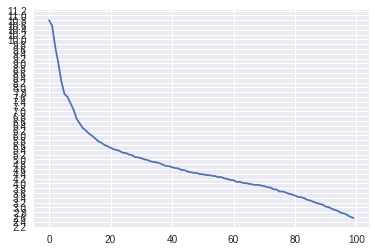

In [0]:
trainIters_sample(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder.state_dict(), folder_path + 'encoder_1204.pt')
torch.save(decoder.state_dict(), folder_path + 'decoder_1204.pt')

Continue training the model. Dec 5th


In [0]:
# Configure models
hidden_size = 500
layers = 3
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000

# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

encoder.load_state_dict(torch.load(folder_path + "encoder_1204.pt"))
decoder.load_state_dict(torch.load(folder_path +"decoder_1204.pt"))

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

In [0]:
# Configure models
hidden_size = 500
layers = 3
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder.load_state_dict(torch.load(folder_path + "encoder_1207.pt"))
decoder.load_state_dict(torch.load(folder_path +"decoder_1207.pt"))


In [0]:
torch.save(encoder.state_dict(), folder_path + 'encoder_1208.pt')
torch.save(decoder.state_dict(), folder_path + 'decoder_1208.pt')

In [0]:
decoded, actual = evaluate_batch(val_loader, encoder, decoder)

for i in zip(decoded, actual):
    if i == 10:
        break
    print('\n')
    print('Expected:', i[1])
    print('Actual:' ,i[0])



Expected:  She retired two years ago only to turn our house into a school for girls and women in our neighborhood .
Actual:  She was a the old and the and the and the of the United States .


Expected:  There was a big smile on his face which was unusual then because the news mostly depressed him .
Actual:  If he was a little time of the same time that he has to be a good time .


Expected:  And my father that s him he was the first ever in his family to receive an education .
Actual:  My father is a of a .


Expected:  We all knew we were risking our lives the teacher the students and our parents .
Actual:  We have to be a very good way of the same time and we re going to be very much to be a very good time .


Expected:  When I was I remember waking up one morning to the sound of joy in my house .
Actual:  I was a was by the of the of the time I was a .


Expected:  I didn t know what it meant but I could see that my father was very very happy .
Actual:  I m very really very very g

In [0]:
evaluate_bleu(decoded,actual)

1.2779485402890656

In [0]:
# Configure models
hidden_size = 500
layers = 3
teacher_forcing_ratio = 1.0
learning_rate = 0.00005
decoder_learning_ratio = 5.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder.load_state_dict(torch.load(folder_path + "encoder_1208.pt"))
decoder.load_state_dict(torch.load(folder_path +"decoder_1208.pt"))


1m 33s (- 154m 22s) (100 1%) 4.2874
3m 7s (- 153m 3s) (200 2%) 4.2487
4m 41s (- 151m 26s) (300 3%) 4.2149
6m 14s (- 149m 45s) (400 4%) 4.2255
7m 47s (- 148m 9s) (500 5%) 4.2003
9m 21s (- 146m 35s) (600 6%) 4.1993
10m 54s (- 144m 59s) (700 7%) 4.1834
12m 28s (- 143m 24s) (800 8%) 4.1963
14m 1s (- 141m 51s) (900 9%) 4.1464
15m 35s (- 140m 17s) (1000 10%) 4.1820
17m 8s (- 138m 42s) (1100 11%) 4.1819
18m 42s (- 137m 11s) (1200 12%) 4.1626
20m 16s (- 135m 42s) (1300 13%) 4.1621
21m 50s (- 134m 11s) (1400 14%) 4.1452
23m 24s (- 132m 40s) (1500 15%) 4.1695
24m 59s (- 131m 9s) (1600 16%) 4.1382
26m 33s (- 129m 37s) (1700 17%) 4.1314
28m 7s (- 128m 5s) (1800 18%) 4.1488
29m 41s (- 126m 34s) (1900 19%) 4.1433
31m 15s (- 125m 2s) (2000 20%) 4.1390
32m 49s (- 123m 30s) (2100 21%) 4.1495
34m 24s (- 121m 58s) (2200 22%) 4.1551
35m 58s (- 120m 26s) (2300 23%) 4.1584
37m 32s (- 118m 53s) (2400 24%) 4.1149
39m 7s (- 117m 21s) (2500 25%) 4.1226
40m 41s (- 115m 48s) (2600 26%) 4.1259
42m 15s (- 114m 15s)

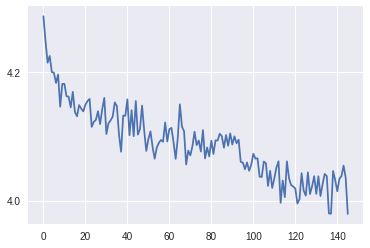

In [0]:
trainIters(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder.state_dict(), folder_path + 'encoder_1208.pt')
torch.save(decoder.state_dict(), folder_path + 'decoder_1208.pt')

In [0]:
decoded, actual = evaluate_batch(val_loader, encoder, decoder)

for i in zip(decoded, actual):
    if i == 10:
        break
    print('\n')
    print('Expected:', i[1])
    print('Actual:' ,i[0])



Expected:  She retired two years ago only to turn our house into a school for girls and women in our neighborhood .
Actual:  She s a year old years old and women were a family who were going to get home in the hospital .


Expected:  There was a big smile on his face which was unusual then because the news mostly depressed him .
Actual:  He s most most likely but most of the most times of the most times of the most times of it is .


Expected:  And my father that s him he was the first ever in his family to receive an education .
Actual:  My father he was a person who was born in his family .


Expected:  We all knew we were risking our lives the teacher the students and our parents .
Actual:  We know that that s all that that s all of us is that kids are going to be very happy .


Expected:  When I was I remember waking up one morning to the sound of joy in my house .
Actual:  I was in night day day day day day day day day day day day day day .


Expected:  I didn t know what it mea

In [0]:
evaluate_bleu(decoded,actual)

3.019498661522269

## Best Model

In [0]:
# Configure models
hidden_size = 1000
layers = 1
teacher_forcing_ratio = 1.0
learning_rate = 0.001
decoder_learning_ratio = 2.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)


In [0]:
trainIters(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, 'BEST',print_every=100, plot_every=100, evaluate_every = 1000,learning_rate=learning_rate)

2m 16s (- 225m 46s) (100 1%) 6.6896
4m 36s (- 226m 11s) (200 2%) 5.6986
6m 57s (- 224m 50s) (300 3%) 5.3776
9m 17s (- 222m 53s) (400 4%) 5.1674
11m 37s (- 220m 55s) (500 5%) 5.0189
13m 58s (- 218m 50s) (600 6%) 4.9158
16m 19s (- 216m 51s) (700 7%) 4.8277
18m 39s (- 214m 34s) (800 8%) 4.7689
20m 59s (- 212m 15s) (900 9%) 4.7025
23m 19s (- 209m 56s) (1000 10%) 4.6367


bleu score:1.194668754899199
26m 38s (- 215m 31s) (1100 11%) 4.6103
28m 58s (- 212m 27s) (1200 12%) 4.5555
31m 18s (- 209m 33s) (1300 13%) 4.4658
33m 38s (- 206m 40s) (1400 14%) 4.4118
35m 57s (- 203m 47s) (1500 15%) 4.3819
38m 17s (- 201m 1s) (1600 16%) 4.3388
40m 38s (- 198m 26s) (1700 17%) 4.3053
42m 58s (- 195m 44s) (1800 18%) 4.2687
45m 18s (- 193m 7s) (1900 19%) 4.2362
47m 38s (- 190m 32s) (2000 20%) 4.1719


bleu score:1.9638480674007721
50m 57s (- 191m 43s) (2100 21%) 4.1607
53m 17s (- 188m 57s) (2200 22%) 4.1373
55m 37s (- 186m 13s) (2300 23%) 4.1112
57m 57s (- 183m 33s) (2400 24%) 4.0553
60m 17s (- 180m 53s) (2500 25%) 4.0421
62m 37s (- 178m 14s) (2600 26%) 4.0058
64m 57s (- 175m 37s) (2700 27%) 4.0051
67m 17s (- 173m 1s) (2800 28%) 3.9717
69m 36s (- 170m 25s) (2900 28%) 3.9472
71m 54s (- 167m 48s) (3000 30%) 3.9272


bleu score:2.6312128986539896
75m 13s (- 167m 26s) (3100 31%) 3.8981
77m 32s (- 164m 46s) (3200 32%) 3.8726
79m 50s (- 162m 6s) (3300 33%) 3.8369
82m 9s (- 159m 29s) (3400 34%) 3.8267
84m 27s (- 156m 51s) (3500 35%) 3.8200
86m 46s (- 154m 15s) (3600 36%) 3.7806
89m 4s (- 151m 40s) (3700 37%) 3.7670
91m 22s (- 149m 5s) (3800 38%) 3.7249
93m 40s (- 146m 31s) (3900 39%) 3.7564
95m 59s (- 143m 59s) (4000 40%) 3.7173


bleu score:3.5705340092309834
99m 16s (- 142m 51s) (4100 41%) 3.7049
101m 34s (- 140m 16s) (4200 42%) 3.7016
103m 53s (- 137m 42s) (4300 43%) 3.6797
106m 12s (- 135m 10s) (4400 44%) 3.6681
108m 30s (- 132m 37s) (4500 45%) 3.6460
110m 48s (- 130m 4s) (4600 46%) 3.6586
113m 6s (- 127m 32s) (4700 47%) 3.6167
115m 23s (- 125m 0s) (4800 48%) 3.6173
117m 41s (- 122m 29s) (4900 49%) 3.5381
119m 59s (- 119m 59s) (5000 50%) 3.1504


bleu score:3.7055472396272444
123m 19s (- 118m 29s) (5100 51%) 3.1891
125m 38s (- 115m 58s) (5200 52%) 3.1853
127m 55s (- 113m 27s) (5300 53%) 3.1752
130m 14s (- 110m 57s) (5400 54%) 3.1711
132m 33s (- 108m 27s) (5500 55%) 3.1879
134m 53s (- 105m 58s) (5600 56%) 3.1827
137m 12s (- 103m 30s) (5700 56%) 3.1900
139m 31s (- 101m 1s) (5800 57%) 3.1686
141m 50s (- 98m 34s) (5900 59%) 3.2046
144m 9s (- 96m 6s) (6000 60%) 3.1854


bleu score:4.832170727383016
147m 21s (- 94m 12s) (6100 61%) 3.1807
149m 38s (- 91m 42s) (6200 62%) 3.2136
151m 54s (- 89m 13s) (6300 63%) 3.1726
154m 11s (- 86m 43s) (6400 64%) 3.1991
156m 27s (- 84m 15s) (6500 65%) 3.1823
158m 45s (- 81m 46s) (6600 66%) 3.1657
161m 2s (- 79m 19s) (6700 67%) 3.1693
163m 20s (- 76m 51s) (6800 68%) 3.1652
165m 37s (- 74m 24s) (6900 69%) 3.1695
167m 54s (- 71m 57s) (7000 70%) 3.1886


bleu score:5.242559460215671
171m 10s (- 69m 54s) (7100 71%) 3.1512
173m 28s (- 67m 27s) (7200 72%) 3.1640
175m 47s (- 65m 1s) (7300 73%) 3.1393
178m 5s (- 62m 34s) (7400 74%) 3.1830
180m 25s (- 60m 8s) (7500 75%) 3.1416
182m 44s (- 57m 42s) (7600 76%) 3.1244
185m 3s (- 55m 16s) (7700 77%) 3.1551
187m 22s (- 52m 50s) (7800 78%) 3.1515
189m 41s (- 50m 25s) (7900 79%) 3.1264
191m 59s (- 47m 59s) (8000 80%) 3.1456


bleu score:5.246490155078735
195m 12s (- 45m 47s) (8100 81%) 3.1280
197m 30s (- 43m 21s) (8200 82%) 3.1221
199m 47s (- 40m 55s) (8300 83%) 3.1284
202m 4s (- 38m 29s) (8400 84%) 3.1324
204m 21s (- 36m 3s) (8500 85%) 3.1284
206m 39s (- 33m 38s) (8600 86%) 3.1289
208m 57s (- 31m 13s) (8700 87%) 3.1225
211m 15s (- 28m 48s) (8800 88%) 3.1162
213m 33s (- 26m 23s) (8900 89%) 3.1187
215m 51s (- 23m 59s) (9000 90%) 3.1254


bleu score:5.528118000570659
219m 3s (- 21m 39s) (9100 91%) 3.1155
221m 22s (- 19m 14s) (9200 92%) 3.1438
223m 40s (- 16m 50s) (9300 93%) 3.1131
225m 59s (- 14m 25s) (9400 94%) 3.0781
228m 19s (- 12m 1s) (9500 95%) 3.1129
230m 37s (- 9m 36s) (9600 96%) 3.0866
232m 55s (- 7m 12s) (9700 97%) 3.0881
235m 13s (- 4m 48s) (9800 98%) 2.7980
237m 30s (- 2m 23s) (9900 99%) 2.3844
239m 41s (- 0m 0s) (10000 100%) 2.4298


bleu score:5.906407696405209
242m 37s (- -3m 35s) (10100 101%) 2.4700
244m 43s (- -5m 12s) (10200 102%) 2.4723
246m 48s (- -8m 48s) (10300 103%) 2.5014
248m 54s (- -10m 25s) (10400 104%) 2.4793
251m 0s (- -12m 2s) (10500 105%) 2.4991
253m 5s (- -15m 40s) (10600 106%) 2.5050
255m 10s (- -17m 18s) (10700 107%) 2.5015
257m 16s (- -20m 56s) (10800 108%) 2.5162
259m 22s (- -22m 35s) (10900 109%) 2.5337
261m 28s (- -24m 13s) (11000 110%) 2.5400


bleu score:5.794733756971175
264m 25s (- -27m 47s) (11100 111%) 2.5617
266m 31s (- -29m 26s) (11200 112%) 2.5287
268m 37s (- -31m 5s) (11300 112%) 2.5737
270m 43s (- -34m 45s) (11400 113%) 2.5796
272m 49s (- -36m 24s) (11500 114%) 2.5742
274m 55s (- -38m 4s) (11600 115%) 2.6028
277m 1s (- -41m 44s) (11700 117%) 2.5931
279m 6s (- -43m 25s) (11800 118%) 2.5901
281m 12s (- -45m 6s) (11900 119%) 2.6161
283m 18s (- -48m 46s) (12000 120%) 2.6036


bleu score:5.20229978159643
286m 16s (- -50m 19s) (12100 121%) 2.5730
288m 21s (- -52m 0s) (12200 122%) 2.5845
290m 27s (- -55m 41s) (12300 123%) 2.6217
292m 33s (- -57m 22s) (12400 124%) 2.6176
294m 39s (- -59m 4s) (12500 125%) 2.6384
296m 45s (- -62m 45s) (12600 126%) 2.6351
298m 51s (- -64m 27s) (12700 127%) 2.6048
300m 57s (- -66m 9s) (12800 128%) 2.6555


KeyboardInterrupt: ignored

In [0]:
# Configure models
hidden_size = 1000
layers = 1
teacher_forcing_ratio = 1.0
learning_rate = 0.00005
decoder_learning_ratio = 2.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder.load_state_dict(torch.load(folder_path + "encoder_BEST.pt"))
decoder.load_state_dict(torch.load(folder_path +"decoder_BEST.pt"))

In [0]:
trainIters(encoder, decoder, encoder_optimizer, decoder_optimizer, n_iters, teacher_forcing_ratio, 'BEST',print_every=100, plot_every=100, evaluate_every = 1000,learning_rate=learning_rate)

2m 1s (- 200m 19s) (100 1%) 1.7682
4m 5s (- 200m 31s) (200 2%) 1.7963
6m 9s (- 199m 18s) (300 3%) 1.7844
8m 14s (- 197m 37s) (400 4%) 1.8021
10m 18s (- 195m 47s) (500 5%) 1.7729
12m 22s (- 193m 48s) (600 6%) 1.8176
14m 26s (- 191m 48s) (700 7%) 1.7934
16m 30s (- 189m 49s) (800 8%) 1.7911
18m 34s (- 187m 47s) (900 9%) 1.8214
20m 38s (- 185m 45s) (1000 10%) 1.7996


bleu score:6.034081265829183
23m 33s (- 190m 32s) (1100 11%) 1.8142
25m 36s (- 187m 50s) (1200 12%) 1.8023
27m 40s (- 185m 13s) (1300 13%) 1.8166
29m 43s (- 182m 37s) (1400 14%) 1.7867
31m 47s (- 180m 9s) (1500 15%) 1.8128
33m 50s (- 177m 40s) (1600 16%) 1.8184
35m 53s (- 175m 15s) (1700 17%) 1.8254
37m 57s (- 172m 53s) (1800 18%) 1.8270
40m 0s (- 170m 34s) (1900 19%) 1.7736
42m 3s (- 168m 15s) (2000 20%) 1.8143


bleu score:6.020232708815251
44m 57s (- 169m 6s) (2100 21%) 1.8032
47m 0s (- 166m 38s) (2200 22%) 1.8074
49m 2s (- 164m 12s) (2300 23%) 1.7996
51m 5s (- 161m 48s) (2400 24%) 1.7974
53m 8s (- 159m 26s) (2500 25%) 1.8109
55m 11s (- 157m 4s) (2600 26%) 1.8185
57m 14s (- 154m 45s) (2700 27%) 1.8168
59m 17s (- 152m 27s) (2800 28%) 1.8073
61m 20s (- 150m 11s) (2900 28%) 1.8174
63m 23s (- 147m 55s) (3000 30%) 1.8065


bleu score:6.240101807144915
66m 17s (- 147m 33s) (3100 31%) 1.8014
68m 20s (- 145m 14s) (3200 32%) 1.7759
70m 24s (- 142m 56s) (3300 33%) 1.8065
72m 27s (- 140m 39s) (3400 34%) 1.8230
74m 30s (- 138m 23s) (3500 35%) 1.8169
76m 34s (- 136m 7s) (3600 36%) 1.8228
78m 37s (- 133m 52s) (3700 37%) 1.7923
80m 40s (- 131m 38s) (3800 38%) 1.8116
82m 44s (- 129m 24s) (3900 39%) 1.7938
84m 47s (- 127m 11s) (4000 40%) 1.8212


bleu score:6.083443703195304
87m 42s (- 126m 12s) (4100 41%) 1.8138
89m 45s (- 123m 56s) (4200 42%) 1.8247
91m 48s (- 121m 41s) (4300 43%) 1.8210
93m 50s (- 119m 26s) (4400 44%) 1.8164
95m 53s (- 117m 12s) (4500 45%) 1.8263
97m 57s (- 114m 59s) (4600 46%) 1.8206
100m 0s (- 112m 45s) (4700 47%) 1.8308
102m 3s (- 110m 33s) (4800 48%) 1.8073
104m 5s (- 108m 20s) (4900 49%) 1.7698
106m 8s (- 106m 8s) (5000 50%) 1.7248


bleu score:5.900894843697884
109m 1s (- 104m 45s) (5100 51%) 1.7033
111m 4s (- 102m 32s) (5200 52%) 1.7011
113m 7s (- 100m 19s) (5300 53%) 1.7177
115m 10s (- 98m 6s) (5400 54%) 1.7243
117m 12s (- 95m 54s) (5500 55%) 1.7191
119m 15s (- 93m 42s) (5600 56%) 1.7077
121m 19s (- 91m 31s) (5700 56%) 1.7183
123m 22s (- 89m 20s) (5800 57%) 1.6765
125m 26s (- 87m 10s) (5900 59%) 1.7135
127m 29s (- 84m 59s) (6000 60%) 1.7383


bleu score:5.982777008429827
130m 22s (- 83m 21s) (6100 61%) 1.7085
132m 25s (- 81m 9s) (6200 62%) 1.7039
134m 28s (- 78m 58s) (6300 63%) 1.7062
136m 31s (- 76m 47s) (6400 64%) 1.6992
138m 33s (- 74m 36s) (6500 65%) 1.7292
140m 36s (- 72m 26s) (6600 66%) 1.7204
142m 39s (- 70m 15s) (6700 67%) 1.7278
144m 42s (- 68m 5s) (6800 68%) 1.7195
146m 45s (- 65m 55s) (6900 69%) 1.7133
148m 47s (- 63m 46s) (7000 70%) 1.7519


bleu score:6.0160525109882785
151m 41s (- 61m 57s) (7100 71%) 1.7045
153m 43s (- 59m 47s) (7200 72%) 1.7004
155m 46s (- 57m 36s) (7300 73%) 1.7109
157m 49s (- 55m 27s) (7400 74%) 1.7318
159m 52s (- 53m 17s) (7500 75%) 1.7154
161m 55s (- 51m 8s) (7600 76%) 1.7268
163m 58s (- 48m 58s) (7700 77%) 1.7000
166m 1s (- 46m 49s) (7800 78%) 1.7317
168m 3s (- 44m 40s) (7900 79%) 1.7454
170m 6s (- 42m 31s) (8000 80%) 1.7145


bleu score:6.427481700837722
172m 58s (- 40m 34s) (8100 81%) 1.7107
175m 1s (- 38m 25s) (8200 82%) 1.7276
177m 3s (- 36m 15s) (8300 83%) 1.7247
179m 6s (- 34m 6s) (8400 84%) 1.7221
181m 9s (- 31m 58s) (8500 85%) 1.7284
183m 11s (- 29m 49s) (8600 86%) 1.7345
185m 14s (- 27m 40s) (8700 87%) 1.7235
187m 17s (- 25m 32s) (8800 88%) 1.7096
189m 19s (- 23m 24s) (8900 89%) 1.7442
191m 22s (- 21m 15s) (9000 90%) 1.7488


bleu score:6.052594841734217


KeyboardInterrupt: ignored

## Testing Model on TestSet

In [0]:
# Configure models
hidden_size = 1000
layers = 1
teacher_forcing_ratio = 1.0
learning_rate = 0.00001
decoder_learning_ratio = 2.0
n_iters = 10000


# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder.load_state_dict(torch.load(folder_path + "encoder_BEST.pt"))
decoder.load_state_dict(torch.load(folder_path +"decoder_BEST.pt"))

In [ ]:
test_en = 'data/test.tok.en'
test_zh = 'data/test.tok.zh'

test_input_lang, test_output_lang, test_pairs = prepareData(test_zh, test_en)
print("print a random pair of test pairs:")
print(random.choice(test_pairs))


In [ ]:
test_dataset = VocabDataset(test_pairs,test_input_lang,test_output_lang)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

In [ ]:
decoded, actual = evaluate_batch(test_loader, encoder, decoder)

for i in zip(decoded, actual):
    if i == 10:
        break
    print('\n')
    print('Expected:', i[1])
    print('Actual:' ,i[0])

In [ ]:
evaluate_bleu(decoded,actual)